# Support set size exploration

In [13]:
import os

import numpy as np
import pandas as pd
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt

# Data access

In [4]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part and "params.support_set_size" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]
    support_set_size = int(params[1].split("=")[1])  # convert to int for numerical operations

    return {"dataset": dataset, "support_set_size": support_set_size}

In [6]:
INPUT_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-20/15-53-19"
run_dirs = [os.path.join(INPUT_DIR, run_dir) for run_dir in os.listdir(INPUT_DIR) if os.path.isdir(os.path.join(INPUT_DIR, run_dir))]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

support_sizes = [8, 16, 32, 64]
datasets = ["clintox", "tox21", "toxcast", "bbbp", "toxval", "nci60", "cancerrx", "prism"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr
    FROM read_parquet('{run_dir}')
    """
    try:
        df = con.execute(query).df()
        df["support_set_size"] = info["support_set_size"]
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} with support set size of {info['support_set_size']}")

        
# Concatenate all dataframes into one
df_final = pd.concat(dfs, ignore_index=True)

# Overall performance by support set size

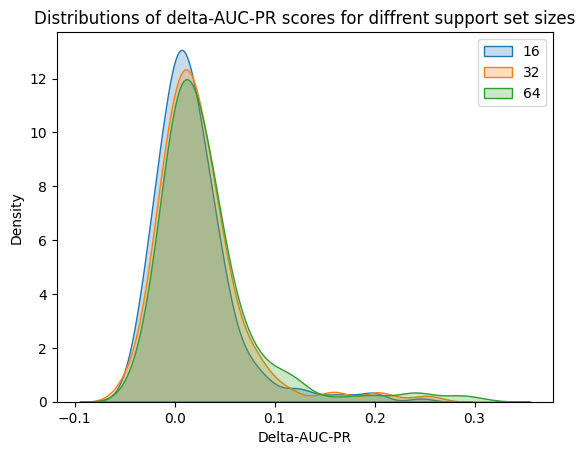

In [7]:
# Create overlapping distribution plots
support_sizes = [16, 32, 64]

for support_size in support_sizes:
    tmp = df_final[df_final["support_set_size"] == support_size]
    sns.kdeplot(x=tmp["delta_auc_pr"], label=support_size, fill=True)

# Provide labels and title
plt.xlabel("Delta-AUC-PR")
plt.ylabel("Density")
plt.title("Distributions of delta-AUC-PR scores for diffrent support set sizes")

# Display the legend
plt.legend()

# Show the plot
plt.show()

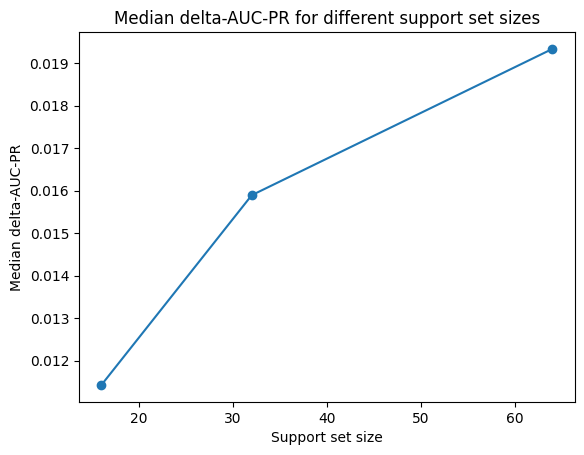

In [8]:
median_vals = []

# Get median delta-AUC-PR for each support set size
for support_size in support_sizes:
    tmp = df_final[df_final["support_set_size"] == support_size]
    median_vals.append(tmp["delta_auc_pr"].median())
    
# Plot median delta-AUC-PR for each support set size as line plot
plt.plot(support_sizes, median_vals, marker="o")
plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different support set sizes")
plt.show()

# Performance by dataset

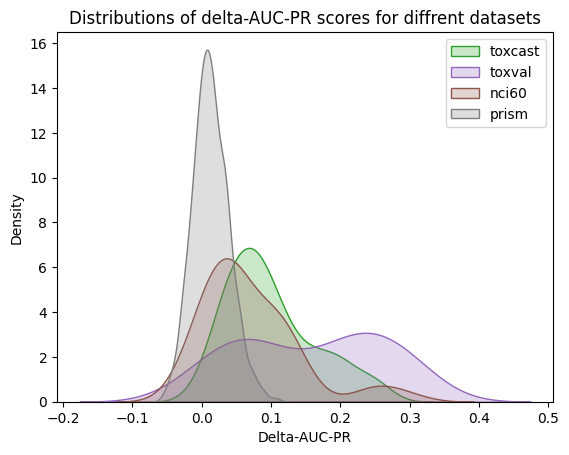

In [9]:
datasets = ["clintox", "tox21", "toxcast", "bbbp", "toxval", "nci60", "cancerrx", "prism"]

# Create overlapping distribution plots
for dataset in datasets:
    tmp = df_final[df_final["dataset"] == dataset]
    sns.kdeplot(x=tmp["delta_auc_pr"], label=dataset, fill=True)

# Provide labels and title
plt.xlabel("Delta-AUC-PR")
plt.ylabel("Density")
plt.title("Distributions of delta-AUC-PR scores for diffrent datasets")

# Display the legend
plt.legend()

# Show the plot
plt.show()

# Performance by dataset by support set size

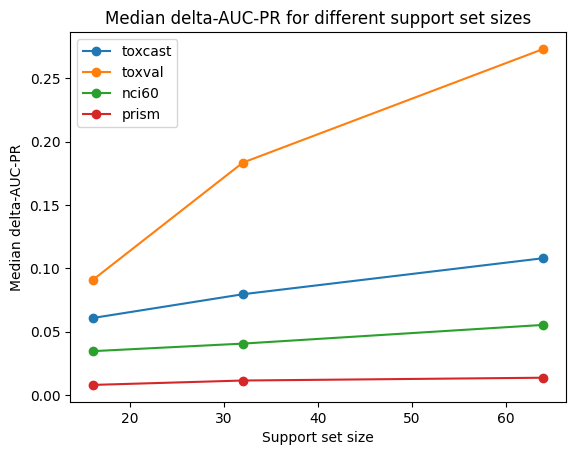

In [10]:
# Get median delta-AUC-PR for each support set size
non_zero_datatsets = []
for dataset in datasets:
    median_vals = []
    for support_size in support_sizes:
        tmp = df_final[(df_final["support_set_size"] == support_size) & (df_final["dataset"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
    
    if len(tmp) != 0:
        # Plot median delta-AUC-PR for each support set size as line plot
        plt.plot(support_sizes, median_vals, marker="o", label=dataset)

plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different support set sizes")
plt.legend()
plt.show()

I will also add some error bars to this plot.

NameError: name 'np' is not defined

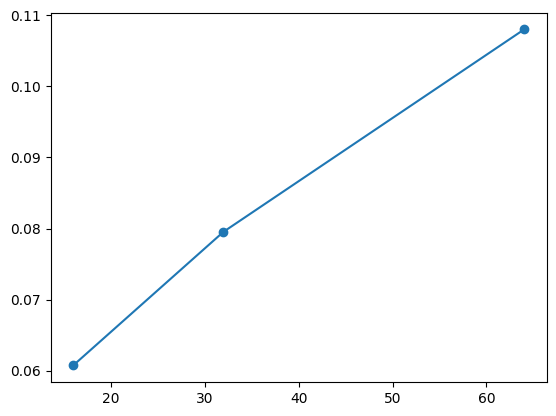

In [11]:
non_zero_datatsets = []
for dataset in datasets:
    median_vals = []
    lower_vals = [] # List to store the lower bounds of the IQR
    upper_vals = [] # List to store the upper bounds of the IQR

    for support_size in support_sizes:
        tmp = df_final[(df_final["support_set_size"] == support_size) & (df_final["dataset"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
        lower_vals.append(tmp["delta_auc_pr"].quantile(0.25)) # Compute Q1
        upper_vals.append(tmp["delta_auc_pr"].quantile(0.75)) # Compute Q3
    
    if len(tmp) != 0:
        # Plot median delta-AUC-PR for each support set size as line plot
        plt.plot(support_sizes, median_vals, marker="o", label=dataset)
        # Plot the IQR as error bars
        plt.errorbar(support_sizes, median_vals, [np.array(median_vals) - np.array(lower_vals), np.array(upper_vals) - np.array(median_vals)], fmt='o')

plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different support set sizes with IQR")
plt.legend()
plt.show()


In [1]:
for dataset in datasets:
    median_vals = []
    lower_vals = []
    upper_vals = []

    for support_size in support_sizes:
        tmp = df_final[(df_final["support_set_size"] == support_size) & (df_final["dataset"] == dataset)]
        median_vals.append(tmp["delta_auc_pr"].median())
        lower_vals.append(tmp["delta_auc_pr"].quantile(0.25))
        upper_vals.append(tmp["delta_auc_pr"].quantile(0.75))

    if len(tmp) != 0:
        plt.errorbar(support_sizes, median_vals, 
                     yerr=[np.array(median_vals) - np.array(lower_vals), np.array(upper_vals) - np.array(median_vals)], 
                     fmt='-o', label=dataset)

plt.grid()
plt.xlabel("Support set size")
plt.ylabel("Median delta-AUC-PR")
plt.title("Median delta-AUC-PR for different support set sizes with IQR")
plt.legend()
plt.show()

NameError: name 'datasets' is not defined